In [1]:
from nltk import sent_tokenize
from flair.nn import Classifier
from tqdm import tqdm
from flair.data import Sentence
from collections import Counter
import pandas as pd
import glob
import os
import re
import string
from scipy.sparse import csr_matrix
import numpy as np
import community
import networkx as nx
from collections import defaultdict
from ast import literal_eval
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt

In [2]:
def read_text(path):
    book = ''
    with open(path, 'r') as f:
        book = f.read()
    return book

In [3]:
def replace_multiple_strings(text, replacements):
    for old_str, new_str in replacements.items():
        text = text.replace(old_str, new_str)
    return text

In [4]:
def get_all_files(path, extension='.preprocessed'):
    return glob.glob(f"{path}/*{extension}")

In [5]:
def store_ner(ners, path):
    df = pd.DataFrame(ners, columns=['name', 'count'])
    replacements = {
        'step00': 'step01',
        'preprocessed': 'ner'
    }
    path_to = replace_multiple_strings(path, replacements)
    new_folder, _  = os.path.split(path_to)
    os.makedirs(new_folder, exist_ok=True)
    df.to_csv(path_to, columns=['name', 'count'], index=False)
    return df

In [6]:
def get_ner(text, tagger):
    sents = sent_tokenize(text)
    x = []
    for line in sents:
        sentence = Sentence(line)
        tagger.predict(sentence)
        for entity in sentence.get_spans('ner'):
            if entity.tag == 'PER':
                x.append(entity.text)
    return Counter(x).most_common()

In [7]:
def correct_name(text):
    pattern = r'([A-Z]) \.'
    replacement = r'\1.'
    result_text = re.sub(pattern, replacement, text)
    return result_text

In [8]:
def create_step00():
    folders = [
        'data/les_cavernes_d_acier/',
        'data/prelude_a_fondation/'
    ]
    for folder in tqdm(folders):
        all_files = get_all_files(folder)
        for path in all_files:
            folder_path, file_name  = os.path.split(path)
            folder_path = folder_path.replace('data', 'baseline')
            new_folder = f'{folder_path}/step00'
            os.makedirs(new_folder, exist_ok=True)
            new_path = f'{new_folder}/{file_name}'
            content = read_text(path)
            content = content.replace('\n', ' ')
            content = re.sub(r'(\w)([.,;!?])', r'\1 \2', content)
            content = re.sub(r'\s+', ' ', content)
            content = correct_name(content)
            
            with open(new_path, 'w') as new_file:
                new_file.write(content)

In [9]:
create_step00()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 34.94it/s]


In [10]:
def step_01(tagger):
    paths = ['baseline/les_cavernes_d_acier/step00/', 'baseline/prelude_a_fondation/step00/']
        
    for path in tqdm(paths):
        replacements = {
            'baseline/':'',
            '/step00/':''
        }
        livre = replace_multiple_strings(path, replacements)
        print(f"Livre: {livre}")
        all_chapter_path = get_all_files(path)
        for chapter_path in all_chapter_path:
            chapter_content = read_text(chapter_path)
            chapter_ner = get_ner(chapter_content, tagger)
            chapter_df = store_ner(chapter_ner, chapter_path)        

In [11]:
tagger = Classifier.load("ner-large")

2024-01-09 12:16:57,454 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


In [12]:
step_01(tagger)

  0%|                                                                                                                                            | 0/2 [00:00<?, ?it/s]

Livre: les_cavernes_d_acier


 50%|█████████████████████████████████████████████████████████████████▌                                                                 | 1/2 [05:53<05:53, 353.48s/it]

Livre: prelude_a_fondation


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [17:40<00:00, 530.01s/it]


In [13]:
def create_step01_count():
    folders = [
        'baseline/les_cavernes_d_acier/step00/',
        'baseline/prelude_a_fondation/step00/'
    ]
    replacements = {'/step00/': '/step01/', '.preprocessed':'.ner'}
    for folder in tqdm(folders):
        all_files = get_all_files(folder)
        for path in all_files:
            new_path = replace_multiple_strings(path, replacements)
            with open(path) as file:
                content = file.read()
    
            df = pd.read_csv(new_path)
            df['count'] = df['name'].apply(lambda x: content.count(x))
            df.to_csv(new_path, index=False)

In [14]:
create_step01_count()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 32.89it/s]


In [15]:
def get_code_livre(path):
    file_path, file_name  = os.path.split(path)
    nom_livre = file_path.split('/')[-1]
    return "lca" if nom_livre == "les_cavernes_d_acier" else "paf"

In [16]:
def get_num_chapitre(path):
    file_path, file_name  = os.path.split(path)
    num_chap = (file_name.split('_')[1]).split('.')[0]
    return num_chap

In [17]:
def find_aliases(names, text, similarity_threshold=90, cluster_distance_threshold=60):
    # Initialize clusters
    clusters = {name: [name] for name in names}

    # Iterate through words in the text
    for word in text.split():
        # Check similarity with each name
        for name in names:
            similarity_score = fuzz.ratio(word.lower(), name.lower())
            
            # If similarity score is above the threshold, consider it an alias
            if similarity_score >= similarity_threshold:
                # Find the cluster to which the name belongs
                for cluster_name, cluster in clusters.items():
                    if name in cluster:
                        # Add the word to the cluster
                        if word not in cluster:
                            cluster.append(word)
    
    # Merge clusters with close distances
    merged_clusters = {}
    for name, cluster in clusters.items():
        if not merged_clusters:
            merged_clusters[name] = cluster
        else:
            merged = False
            for merged_name, merged_cluster in merged_clusters.items():
                if min(fuzz.ratio(name.lower(), alias.lower()) for alias in merged_cluster) >= cluster_distance_threshold:
                    merged_clusters[merged_name].extend(cluster)
                    merged = True
                    break
            if not merged:
                merged_clusters[name] = cluster
    
    return merged_clusters

In [18]:
def store_alias(alias, path):
    codes = [f'CHAR{i}' for i in range(1, len(alias)+1)]
    sorted_alias = [sorted(item, key=len, reverse=True) for item in alias.values()]
    names = [item[0] for item in sorted_alias]
    chapter_dict = {'code':codes, 'name': names, 'alias': sorted_alias}
    chapter_df = pd.DataFrame(chapter_dict)
    replacements = {"step01": "step02", "ner": "alias"} 
    chapter_path = replace_multiple_strings(path, replacements)
    dirname = os.path.dirname(chapter_path)
    os.makedirs(dirname, exist_ok=True)
    chapter_df.to_csv(chapter_path,  index=False)
    return chapter_df

In [19]:
def step_02():
    paths = ['baseline/les_cavernes_d_acier/step00/', 'baseline/prelude_a_fondation/step00/']
        
    for path in tqdm(paths):
        print(f"Livre: {path.split('/')[-3]}")
        all_chapter_path = get_all_files(path)
        for chapter_path in all_chapter_path:
            chapter_content = read_text(chapter_path)
            replacements = {"preprocessed": "ner", "step00": "step01"} 
            chapter_ner_path = replace_multiple_strings(chapter_path, replacements)
            chapter_ner = pd.read_csv(chapter_ner_path)['name'].tolist()
            chapter_aliases = find_aliases(chapter_ner, chapter_content)
            chapter_aliases_df = store_alias(chapter_aliases, chapter_ner_path)

In [20]:
step_02()

  0%|                                                                                                                                            | 0/2 [00:00<?, ?it/s]

Livre: les_cavernes_d_acier


 50%|██████████████████████████████████████████████████████████████████                                                                  | 1/2 [00:00<00:00,  1.19it/s]

Livre: prelude_a_fondation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.25s/it]


In [21]:
pd.read_csv('baseline/les_cavernes_d_acier/step02/chapter_8.txt.alias')

,code,name,alias
0,CHAR1,Baley,['Baley']
1,CHAR2,Enderby,['Enderby']
2,CHAR3,Fastolfe,['Fastolfe']
3,CHAR4,R. Daneel,"['R. Daneel', '. Daneel', 'Daneel']"
4,CHAR5,Sarton,['Sarton']
5,CHAR6,R,['R']
6,CHAR7,Elijah,"['Elijah', 'Lije']"
7,CHAR8,Julius,['Julius']
8,CHAR9,Jessie,['Jessie']
9,CHAR10,Daneel Olivaw,['Daneel Olivaw']


In [22]:
def replace_ner_by_code(path):
    replacements = {
        "preprocessed": "alias", 
        "step00":"step02"
    }
    with open(path) as file:
        content = file.read()
        
    chapter_alias_path = replace_multiple_strings(path, replacements)
    df_ner = pd.read_csv(chapter_alias_path)
    for i, row in df_ner.iterrows():
        code = row['code']
        alias = eval(row['alias'])
        alias = sorted(alias, key=len, reverse=True)
        for a in alias:
            pattern = re.compile(r'\b{}\b'.format(re.escape(a)), re.IGNORECASE)
            content = pattern.sub(code, content)
            
    with open(path, 'w') as file:
        file.write(content)

In [23]:
def correct_step00_01():
    folders = [
        'baseline/les_cavernes_d_acier/step00/',
        'baseline/prelude_a_fondation/step00/'
    ]
    for folder in tqdm(folders):
        all_files = get_all_files(folder)
        for path in all_files:
            replace_ner_by_code(path)

In [24]:
correct_step00_01()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.76it/s]


In [25]:
def remove_punctuation(path):
    with open(path) as file:
        content = file.read()
        
    # Replace punctuaction by space
    puncts = string.punctuation + "’–»«—―‖"
    translator = str.maketrans(puncts, ' ' * len(puncts))
    
    # Use translate to remove punctuation from the text
    content = content.translate(translator)
    content = re.sub(r'\s+', ' ', content)
    with open(path, 'w') as file:
        file.write(content)

In [26]:
def correct_step00_02():
    folders = [
        'baseline/les_cavernes_d_acier/step00/',
        'baseline/prelude_a_fondation/step00/'
    ]
    for folder in tqdm(folders):
        all_files = get_all_files(folder)
        for path in all_files:
            remove_punctuation(path)

In [27]:
correct_step00_02()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 39.29it/s]


In [28]:
def generate_idx_dict(path):
    """
    create an idx_dct where the keys are the idx of the names in
    the text and the values are the names
    """
    folder_path, file_name  = os.path.split(path)
    replacements = {
        "preprocessed": "alias", 
        "step00": "step02"
    } 
    alias_path = replace_multiple_strings(path, replacements)
    text = read_text(path)
    names_df = pd.read_csv(alias_path)
    res = dict()
    for i, word in enumerate(text.split(' ')):
        for _,row in names_df.iterrows():
            if word != row['code']:
                continue
            if len(res) > 0:
                last_idx = list(res.keys())[-1]
                if res[last_idx] != row['name']:
                    res[i] = row['name']
                    break
            else:
                res[i] = row['name']
                break
                                
    return res

In [29]:
lca_01 = generate_idx_dict('baseline/les_cavernes_d_acier/step00/chapter_1.txt.preprocessed')

In [30]:
lca_01

{50: 'Simpson',
 58: 'R. Sammy',
 78: 'Vince Barrett',
 110: 'R. Sammy',
 129: 'Vince',
 158: 'Aussi Baley',
 200: 'JULIUS ENDERBY',
 227: 'Aussi Baley',
 239: 'JULIUS ENDERBY',
 298: 'Aussi Baley',
 581: 'Lije',
 611: 'Aussi Baley',
 683: 'JULIUS ENDERBY',
 713: 'Julius',
 800: 'Lije',
 877: 'Aussi Baley',
 1022: 'JULIUS ENDERBY',
 1101: 'Aussi Baley',
 1378: 'Roj Nemennuh Sarton',
 1496: 'Aussi Baley',
 1540: 'Julius',
 1580: 'Aussi Baley',
 1609: 'JULIUS ENDERBY',
 1702: 'Aussi Baley',
 1732: 'Lije',
 1734: 'JULIUS ENDERBY',
 1851: 'Lije',
 1953: 'Aussi Baley',
 2010: 'Jessie',
 2046: 'Lije',
 2048: 'JULIUS ENDERBY',
 2104: 'Lije',
 2208: 'Jessie',
 2292: 'Lije',
 2303: 'Aussi Baley',
 2315: 'JULIUS ENDERBY',
 2357: 'Aussi Baley',
 2361: 'Pierre',
 2362: 'Jacques',
 2364: 'Paul',
 2382: 'Lije',
 2397: 'Aussi Baley',
 2422: 'Robot Daneel Olivaw'}

In [31]:
def find_interactions(idx_dct, N=25):
    res = defaultdict(int)
    names = list(idx_dct.keys())
    
    for i,na in enumerate(names):
        # given an index, get the sublist of all indicies greater than the current index
        if i < len(names) - 1:
            kl = names[i+1:]
        else:
            kl = []
        
        # for each idx greater than the current, check if its found in the range of N
        for k in kl:
            if k-na < N:
                # get names found in current position (na) and index greater than current but in rnage N (k)
                n1 = idx_dct[na]
                n2 = idx_dct[k]
                
                key = tuple(sorted([n1,n2]))
                if n1 != n2:
                    res[key]+=1
    return res

In [32]:
lca_01

{50: 'Simpson',
 58: 'R. Sammy',
 78: 'Vince Barrett',
 110: 'R. Sammy',
 129: 'Vince',
 158: 'Aussi Baley',
 200: 'JULIUS ENDERBY',
 227: 'Aussi Baley',
 239: 'JULIUS ENDERBY',
 298: 'Aussi Baley',
 581: 'Lije',
 611: 'Aussi Baley',
 683: 'JULIUS ENDERBY',
 713: 'Julius',
 800: 'Lije',
 877: 'Aussi Baley',
 1022: 'JULIUS ENDERBY',
 1101: 'Aussi Baley',
 1378: 'Roj Nemennuh Sarton',
 1496: 'Aussi Baley',
 1540: 'Julius',
 1580: 'Aussi Baley',
 1609: 'JULIUS ENDERBY',
 1702: 'Aussi Baley',
 1732: 'Lije',
 1734: 'JULIUS ENDERBY',
 1851: 'Lije',
 1953: 'Aussi Baley',
 2010: 'Jessie',
 2046: 'Lije',
 2048: 'JULIUS ENDERBY',
 2104: 'Lije',
 2208: 'Jessie',
 2292: 'Lije',
 2303: 'Aussi Baley',
 2315: 'JULIUS ENDERBY',
 2357: 'Aussi Baley',
 2361: 'Pierre',
 2362: 'Jacques',
 2364: 'Paul',
 2382: 'Lije',
 2397: 'Aussi Baley',
 2422: 'Robot Daneel Olivaw'}

In [33]:
find_interactions(lca_01)

defaultdict(int,
            {('R. Sammy', 'Simpson'): 1,
             ('R. Sammy', 'Vince Barrett'): 1,
             ('R. Sammy', 'Vince'): 1,
             ('Aussi Baley', 'JULIUS ENDERBY'): 2,
             ('JULIUS ENDERBY', 'Lije'): 3,
             ('Aussi Baley', 'Lije'): 2,
             ('Aussi Baley', 'Pierre'): 1,
             ('Aussi Baley', 'Jacques'): 1,
             ('Aussi Baley', 'Paul'): 1,
             ('Jacques', 'Pierre'): 1,
             ('Paul', 'Pierre'): 1,
             ('Lije', 'Pierre'): 1,
             ('Jacques', 'Paul'): 1,
             ('Jacques', 'Lije'): 1,
             ('Lije', 'Paul'): 1})

In [34]:
def store_interaction(int_dict, path):
    data = []
    for key, weight in int_dict.items():
        data.append((key[0], key[1], weight))
        
    alias_df = pd.DataFrame(data, columns=['source', 'target', 'weight'])

    replacements = {"step00": "step03", "preprocessed": "interact"} 
    alias_path = replace_multiple_strings(path, replacements)

    dirname = os.path.dirname(alias_path)
    os.makedirs(dirname, exist_ok=True)

    alias_df.to_csv(alias_path,  index=False)

In [35]:
def step_03():
    paths = [
        'baseline/les_cavernes_d_acier/step00/', 
        'baseline/prelude_a_fondation/step00/'
    ]        
    for path in tqdm(paths):
        livre = replace_multiple_strings(path, {'baseline/':'','/step00/':''})
        print(f"Livre: {livre}")
        all_chapter_path = get_all_files(path)
        for chapter_path in all_chapter_path:
            names_idx = generate_idx_dict(chapter_path)
            int_dict = find_interactions(names_idx)
            store_interaction(int_dict, chapter_path) 

In [36]:
step_03()

  0%|                                                                                                                                            | 0/2 [00:00<?, ?it/s]

Livre: les_cavernes_d_acier


 50%|██████████████████████████████████████████████████████████████████                                                                  | 1/2 [00:06<00:06,  6.49s/it]

Livre: prelude_a_fondation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:18<00:00,  9.25s/it]


In [37]:
def get_id_graph(path):
    file_path, file_name  = os.path.split(path)
    nom_livre = file_path.split('/')[-2]
    code_livre = "lca" if nom_livre == "les_cavernes_d_acier" else "paf"
    num_chap = int((file_name.split('_')[1]).split('.')[0]) - 1
    return f"{code_livre}{num_chap}"

In [38]:
def create_graph(path):
    edges_df = pd.read_csv(path)
    G = nx.from_pandas_edgelist(edges_df, edge_attr = True)
    nodes = list(G.nodes)
    replacements = {"step03": "step02", "interact": "alias"} 
    alias_path = replace_multiple_strings(path, replacements)
    alias_df = pd.read_csv(alias_path)
    for _, row in alias_df.iterrows():
        if row['name'] in nodes:
            names = eval(row['alias'])
            G.nodes[row['name']]['names'] = ";".join(names)
    return G

In [39]:
def step_04(paths=None):
    paths = ['baseline/les_cavernes_d_acier/step03/', 'baseline/prelude_a_fondation/step03/']
        
    graph_dict = {'ID': [], 'graphml': []}
    for path in tqdm(paths):
        print(f"Livre: {path.split('/')[-3]}")
        all_chapter_path = get_all_files(path, ".interact")
        for chapter_path in all_chapter_path:
            graph_dict['ID'].append(get_id_graph(chapter_path))
            G = create_graph(chapter_path)
            graphml = "".join(nx.generate_graphml(G))
            graph_dict['graphml'].append(graphml)
    
    graph_df = pd.DataFrame(graph_dict)
    graph_df.set_index("ID", inplace=True)
    graph_df.to_csv("baseline/my_submission.csv")

In [40]:
step_04()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 33.66it/s]

Livre: les_cavernes_d_acier
Livre: prelude_a_fondation


In [41]:
def create_graphs():
    paths = [
        'baseline/les_cavernes_d_acier/step03/', 
        'baseline/prelude_a_fondation/step03/'
    ]
        
    graph_dict = {'ID': [], 'graphml': []}
    graphs = {}
    for path in paths:
        all_chapter_path = get_all_files(path, ".interact")
        livre = replace_multiple_strings(path, {'baseline/':'','/step03/':''})
        print(f"Livre: {livre}")
        for chapter_path in all_chapter_path:
            key_1 = f'{path}chapter_'
            chapitre = replace_multiple_strings(chapter_path, 
                                                {
                                                    key_1:'',
                                                     '.txt.interact':''
                                                })
            G = create_graph(chapter_path)
            gid = f'{livre}_{chapitre}'
            graphs[gid] = G       
    return graphs

In [42]:
graphs = create_graphs()

Livre: les_cavernes_d_acier
Livre: prelude_a_fondation


In [43]:
len(graphs)

37

In [44]:
graphs.keys()

dict_keys(['les_cavernes_d_acier_18', 'les_cavernes_d_acier_7', 'les_cavernes_d_acier_15', 'les_cavernes_d_acier_12', 'les_cavernes_d_acier_6', 'les_cavernes_d_acier_1', 'les_cavernes_d_acier_13', 'les_cavernes_d_acier_14', 'les_cavernes_d_acier_3', 'les_cavernes_d_acier_4', 'les_cavernes_d_acier_16', 'les_cavernes_d_acier_11', 'les_cavernes_d_acier_5', 'les_cavernes_d_acier_2', 'les_cavernes_d_acier_10', 'les_cavernes_d_acier_17', 'les_cavernes_d_acier_8', 'les_cavernes_d_acier_9', 'prelude_a_fondation_19', 'prelude_a_fondation_18', 'prelude_a_fondation_7', 'prelude_a_fondation_15', 'prelude_a_fondation_12', 'prelude_a_fondation_6', 'prelude_a_fondation_1', 'prelude_a_fondation_13', 'prelude_a_fondation_14', 'prelude_a_fondation_3', 'prelude_a_fondation_4', 'prelude_a_fondation_16', 'prelude_a_fondation_11', 'prelude_a_fondation_5', 'prelude_a_fondation_2', 'prelude_a_fondation_10', 'prelude_a_fondation_17', 'prelude_a_fondation_8', 'prelude_a_fondation_9'])

In [45]:
def show_graph(graph, title):
    #from pylab import rcParams
    #rcParams['figure.figsize'] = 14, 10
    fig, ax = plt.subplots(figsize=(14, 10))
    pos = nx.circular_layout(graph, scale = 20)
    labels = nx.get_edge_attributes(graph, 'weight')
    d = dict(graph.degree)
    nx.draw(
        graph, 
        pos,
        node_color='lightblue', 
        alpha = 0.75,
        with_labels=True, 
        nodelist=d, 
        node_size=[d[k]*200 for k in d],
        edgelist = labels,
        ax=ax
    )
    nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)
    plt.title(f'Graphe: {title}')
    plt.show()

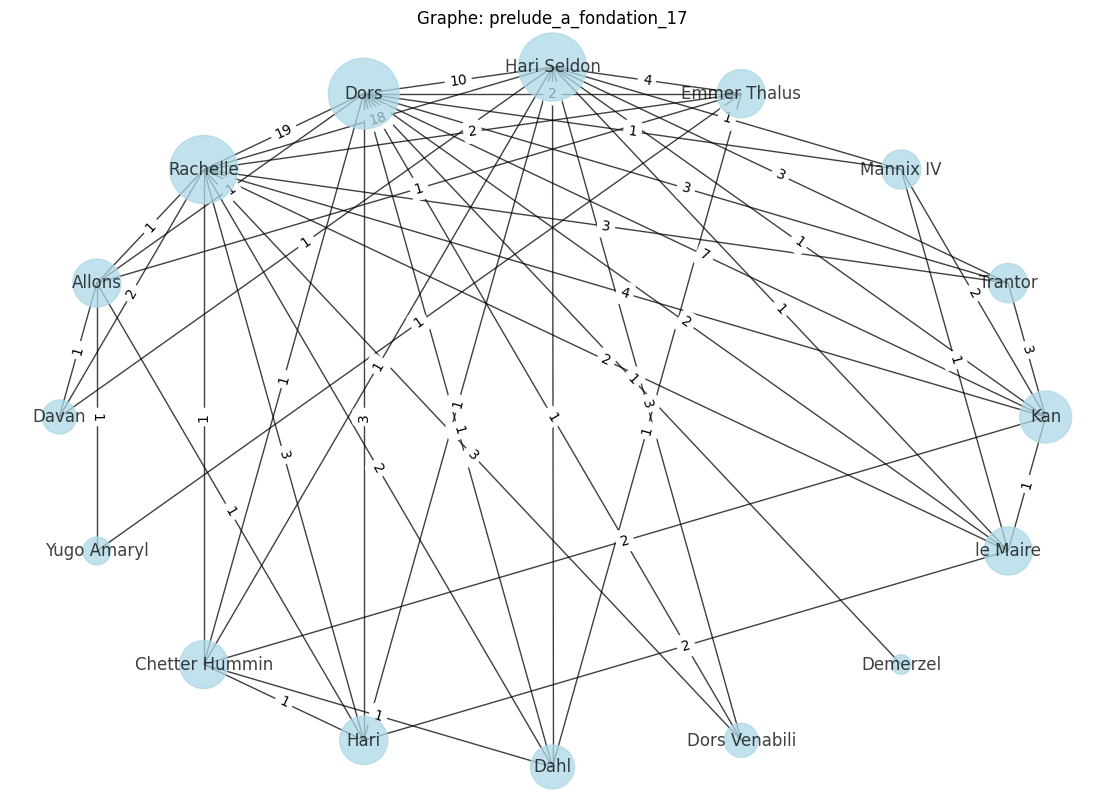

In [46]:
show_graph(graphs['prelude_a_fondation_17'], 'prelude_a_fondation_17')

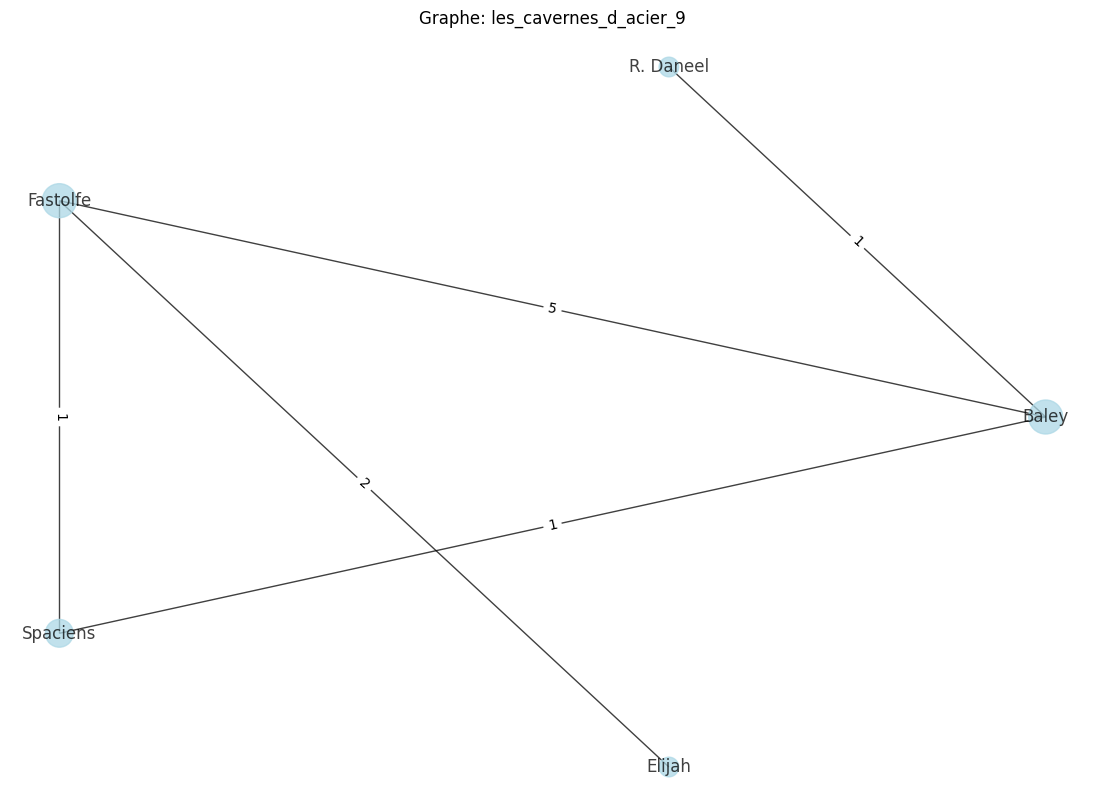

In [47]:
show_graph(graphs['les_cavernes_d_acier_9'], 'les_cavernes_d_acier_9')

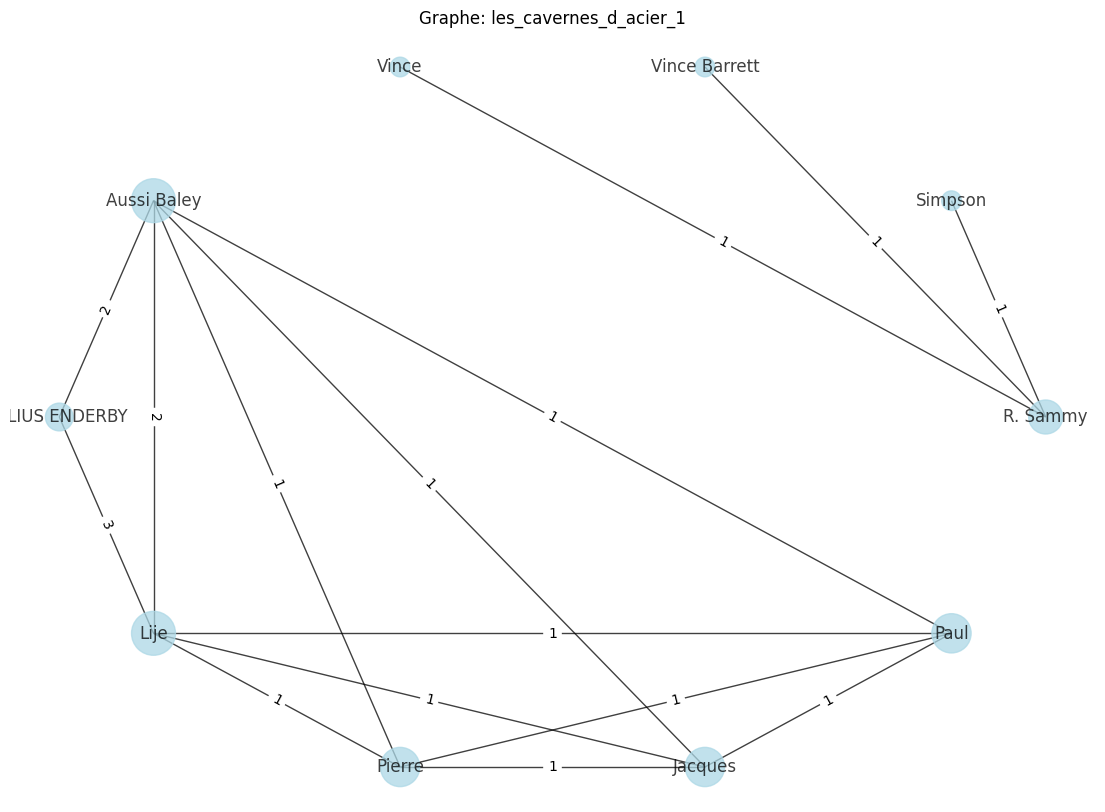

In [48]:
show_graph(graphs['les_cavernes_d_acier_1'], 'les_cavernes_d_acier_1')

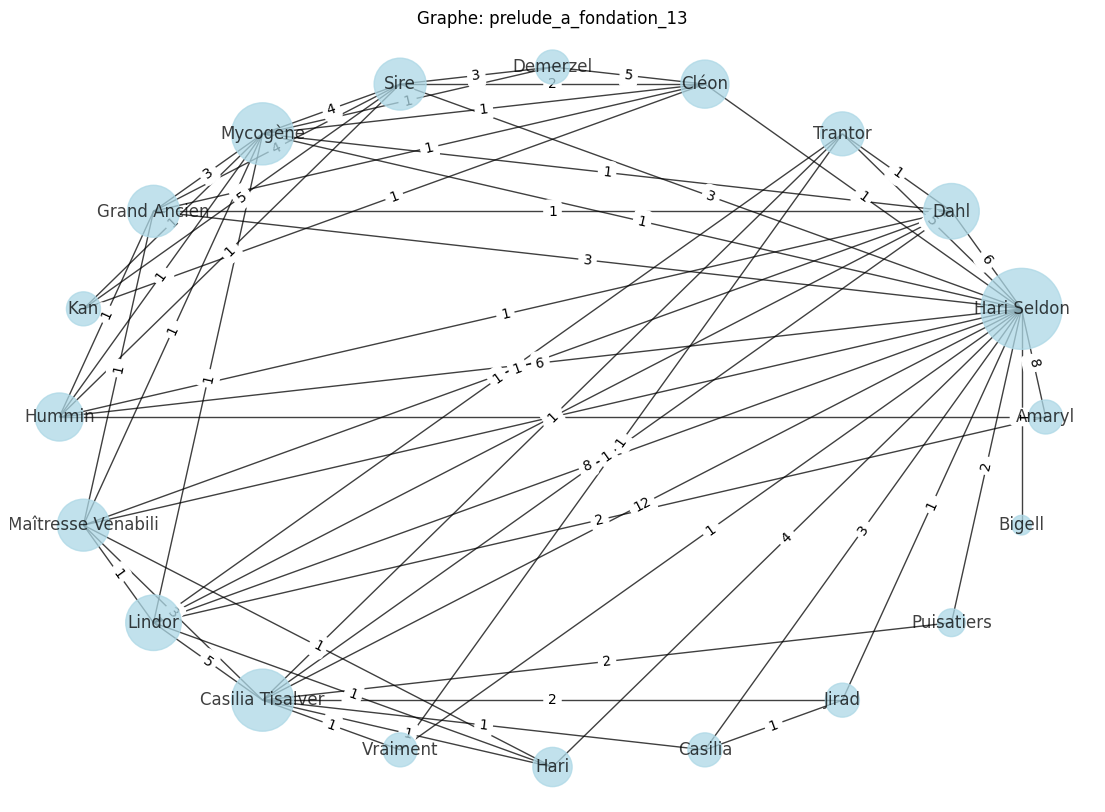

In [49]:
show_graph(graphs['prelude_a_fondation_13'], 'prelude_a_fondation_13')

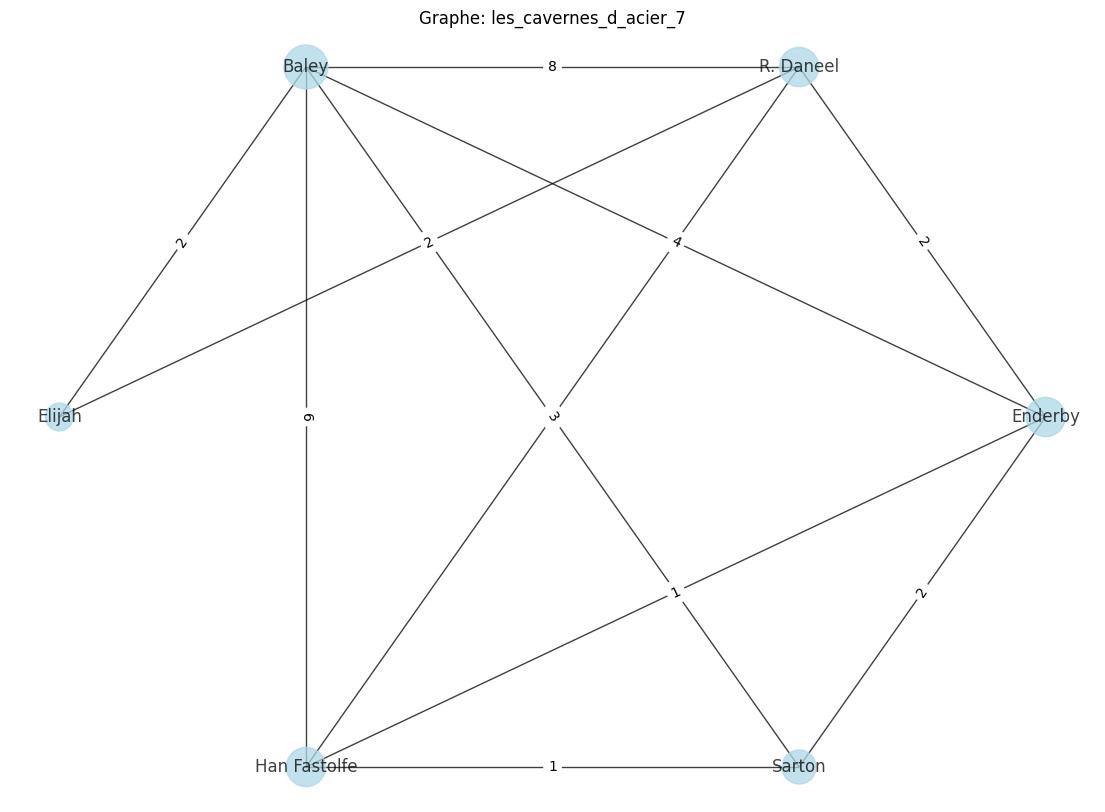

In [50]:
show_graph(graphs['les_cavernes_d_acier_7'], 'les_cavernes_d_acier_7')

In [51]:
def plot_pagerank(graph, title):

    pagerank_scores = nx.pagerank(graph)
    characters = list(pagerank_scores.keys())
    scores = list(pagerank_scores.values())

    plt.bar(characters, scores, color='skyblue')
    plt.xlabel('Characters')
    plt.ylabel('PageRank Score')
    plt.title('PageRank Scores for Characters')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.title(f'Graphe: {title}')
    plt.show()

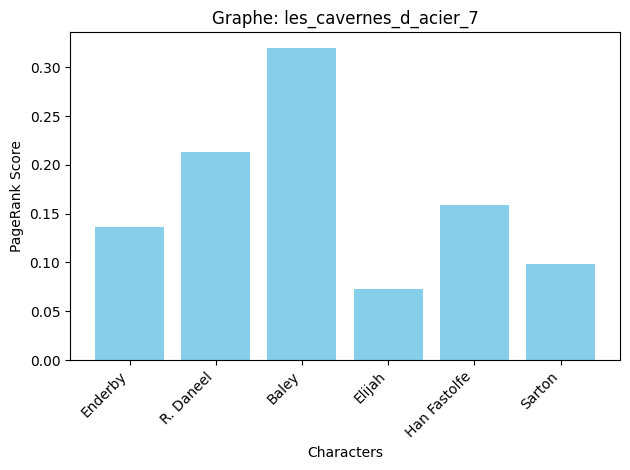

In [52]:
plot_pagerank(graphs['les_cavernes_d_acier_7'], 'les_cavernes_d_acier_7')

In [53]:
def plot_eigenvector(graph, title):
    
    eigenvector_scores = nx.eigenvector_centrality(graph, weight='weight')
    characters = list(eigenvector_scores.keys())
    scores = list(eigenvector_scores.values())

    plt.bar(characters, scores, color='skyblue')
    plt.xlabel('Characters')
    plt.ylabel('Eigenvector Score')
    plt.title('Eigenvector Score for Characters')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.title(f'Graphe: {title}')
    plt.show()

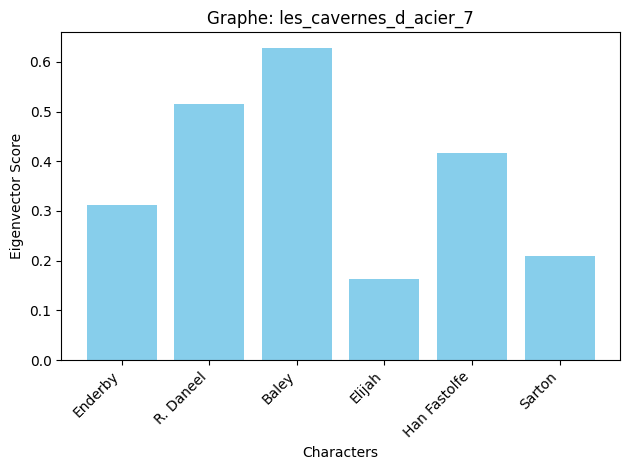

In [54]:
plot_eigenvector(graphs['les_cavernes_d_acier_7'], 'les_cavernes_d_acier_7')

In [55]:
def plot_betweeness(graph, title):
    
    betweenness_scores = nx.betweenness_centrality(graph, weight='weight', seed=0)
    characters = list(betweenness_scores.keys())
    scores = list(betweenness_scores.values())

    plt.bar(characters, scores, color='skyblue')
    plt.xlabel('Characters')
    plt.ylabel('Betweenness Score')
    plt.title('Betweenness Score for Characters')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.title(f'Graphe: {title}')
    plt.show()

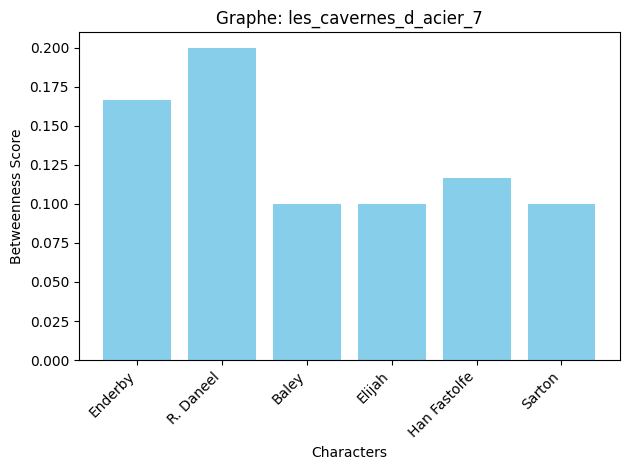

In [56]:
plot_betweeness(graphs['les_cavernes_d_acier_7'], 'les_cavernes_d_acier_7')

In [57]:
def plot_degree(graph, title):
    
    degree_scores = dict(nx.degree(graph, weight='weight'))
    characters = list(degree_scores.keys())
    scores = list(degree_scores.values())

    plt.bar(characters, scores, color='skyblue')
    plt.xlabel('Characters')
    plt.ylabel('Degree Score')
    plt.title('Degree Score for Characters')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.title(f'Graphe: {title}')
    plt.show()

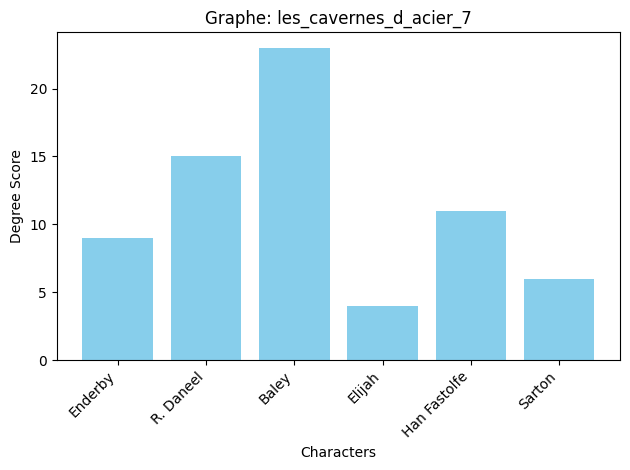

In [58]:
plot_degree(graphs['les_cavernes_d_acier_7'], 'les_cavernes_d_acier_7')

In [59]:
def plot_closeness(graph, title):
    
    closeness_scores = nx.closeness_centrality(graph)
    characters = list(closeness_scores.keys())
    scores = list(closeness_scores.values())

    plt.bar(characters, scores, color='skyblue')
    plt.xlabel('Characters')
    plt.ylabel('Closeness Score')
    plt.title('Closeness Score for Characters')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.title(f'Graphe: {title}')
    plt.show()

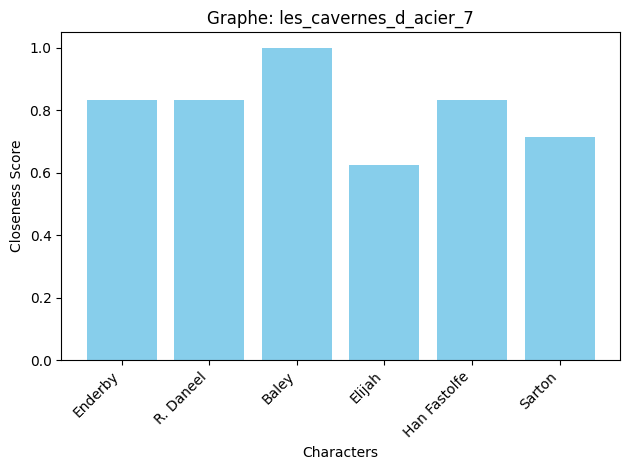

In [60]:
plot_closeness(graphs['les_cavernes_d_acier_7'], 'les_cavernes_d_acier_7')

In [61]:
def show_community_graph(graph, title):
    partition = community.best_partition(graph)
    fig, ax = plt.subplots(figsize=(14, 10))
    pos = nx.circular_layout(graph, scale = 20)
    labels = nx.get_edge_attributes(graph, 'weight')
    d = dict(graph.degree)
    nx.draw(
        graph, 
        pos,
        node_color=list(partition.values()),
        alpha = 0.75,
        with_labels=True, 
        nodelist=d, 
        node_size=[d[k]*200 for k in d],
        edgelist = labels,
        ax=ax
    )
    nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)
    plt.title(f'Graphe: {title}')
    plt.show()

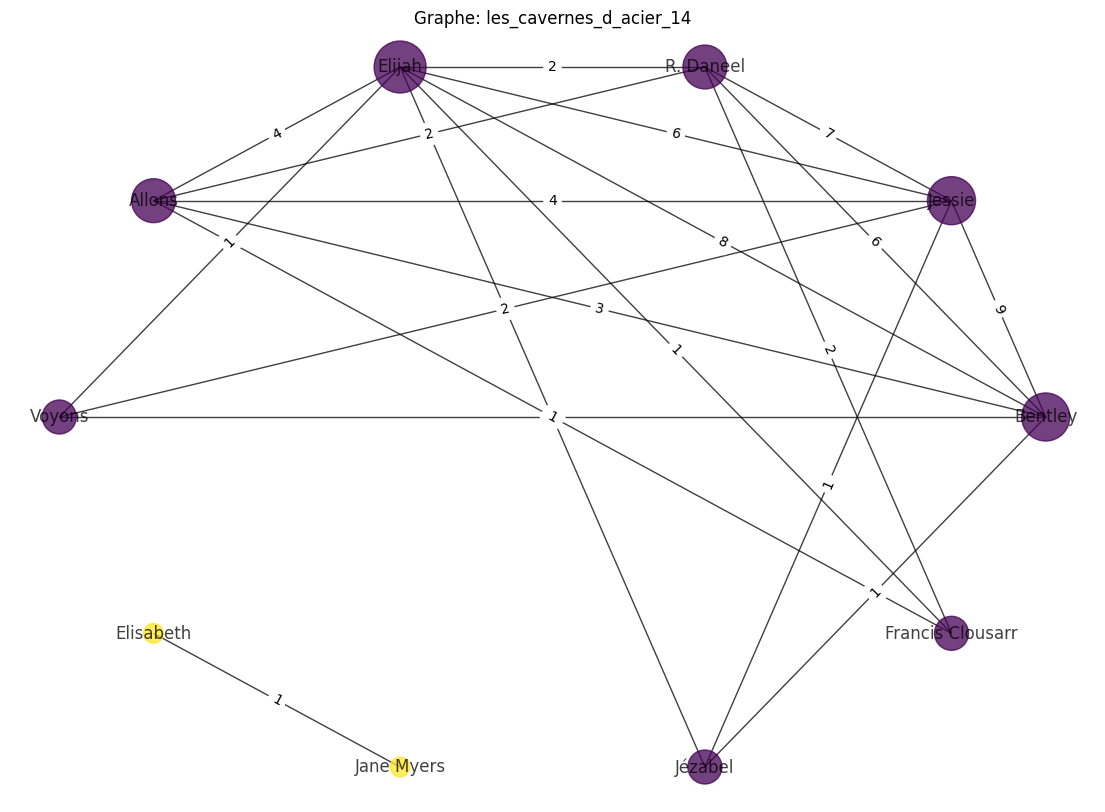

In [62]:
show_community_graph(graphs['les_cavernes_d_acier_14'], 'les_cavernes_d_acier_14')

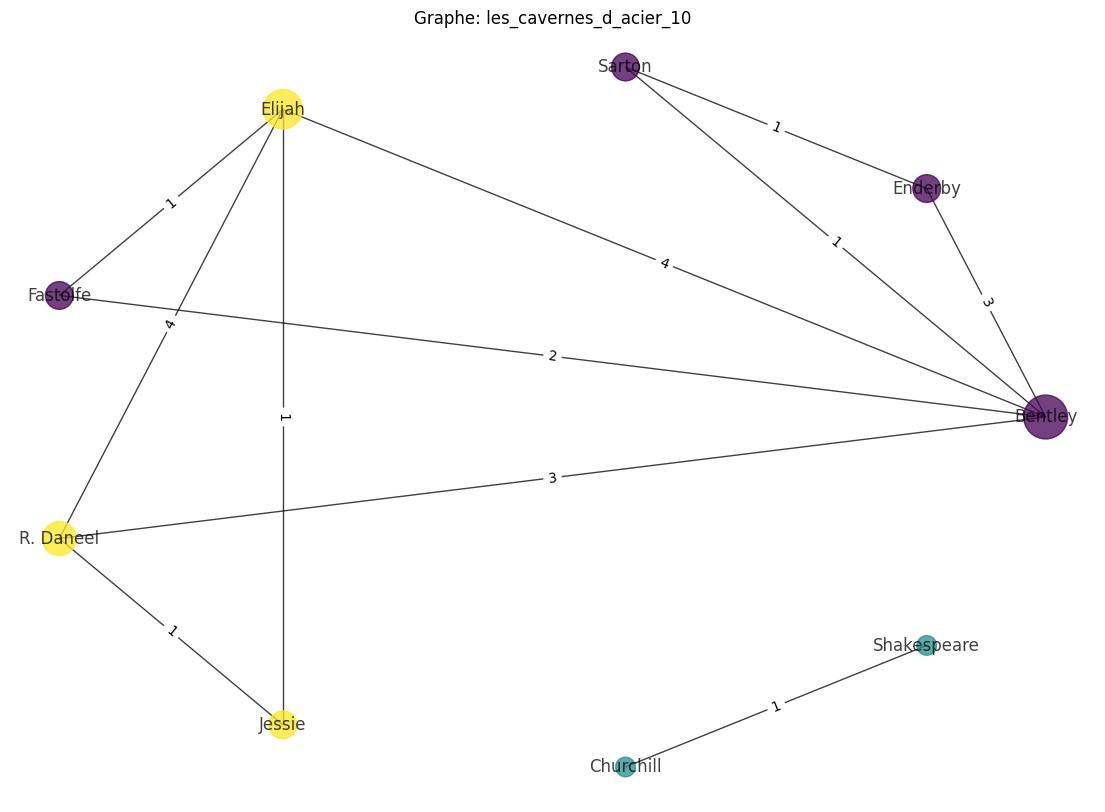

In [63]:
show_community_graph(graphs['les_cavernes_d_acier_10'], 'les_cavernes_d_acier_10')